In [1]:
import classy as Class
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from datetime import datetime
from astropy.cosmology import Planck15 as cosmo
from IPython.display import display, clear_output
from matplotlib.colors import LogNorm
from matplotlib import cm
import scipy.interpolate
sys.path.insert(0, '/Users/gabe/projects/recombination/src')
import RunData
from RunData import PCA

%config InlineBackend.figure_format = 'retina'
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]

ModuleNotFoundError: No module named 'RunData'

# No priors

Apr07.PCAplot.0


Text(0.1, 0.9, '$\\sigma^2 = 1.904$')

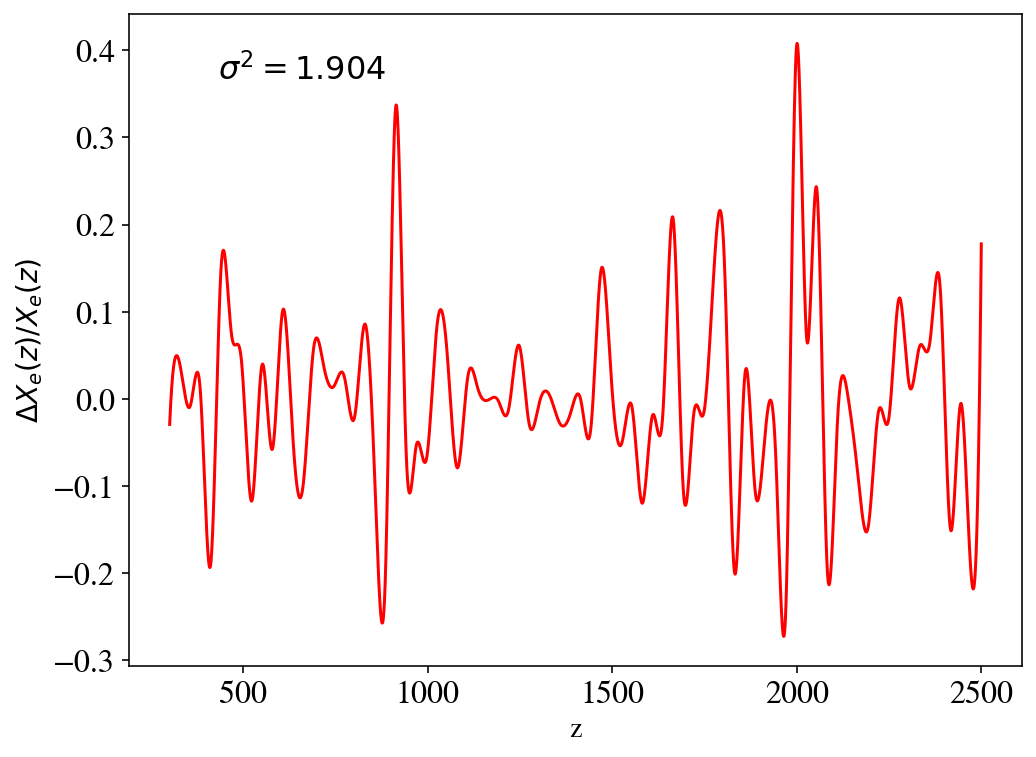

In [2]:
basedir = "/Users/gabe/projects/recombination/data"

key = "PCAplot"
all_data={}
for filename in os.listdir(basedir):
    if(key in filename):
        all_data[filename] =  RunData.RunData(os.path.join(basedir, filename))
        
for key in all_data.keys():
    print(key)
        
data = all_data["Apr07.PCAplot.0"]

Fisher = data.Fisher.copy()

divider = 5

standard_block = Fisher[:divider, :divider]
cross_block = Fisher[:divider, divider:]
perturbation_block = Fisher[divider:, divider:]

marginalized = perturbation_block - np.einsum("ai,ij,jk->ak", cross_block.T, np.linalg.inv(standard_block), cross_block)

H0_row = marginalized[0,1:]
block = marginalized[1:,1:]
binv = np.linalg.inv(block)

mode = np.einsum("i,ij->j", H0_row, binv)

F_00 = marginalized[0,0]
num = np.einsum("a,ab,b", H0_row, binv, H0_row)
sig2 = 1./(F_00-num)

norm = np.abs(np.einsum("i,ij,j", mode.T, binv, mode)) ##normalizing the uncertainty to be unit
norm = np.abs(np.einsum("i,i", mode.T, mode)) ##normalizing the uncertainty to be unit
mode*=1./np.sqrt(norm)

fun = scipy.interpolate.CubicSpline(data.pivots, mode)
zs = np.linspace(data.zmin, data.zmax, 10000)

fig,ax=plt.subplots()
ax.plot(zs, fun(zs), color='r')

ax.set_xlabel("z", fontsize=14)
ax.set_ylabel("$\Delta X_e(z)/X_e(z)$", fontsize=14)

ax.text(0.1, 0.9, "$\sigma^2 = {:.3f}$".format(sig2), transform=ax.transAxes)
#plt.savefig("../results/H0_mode_no_prior.pdf", dpi=300, bbox_inches='tight')

# Prior eigenspec

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80]
80
30


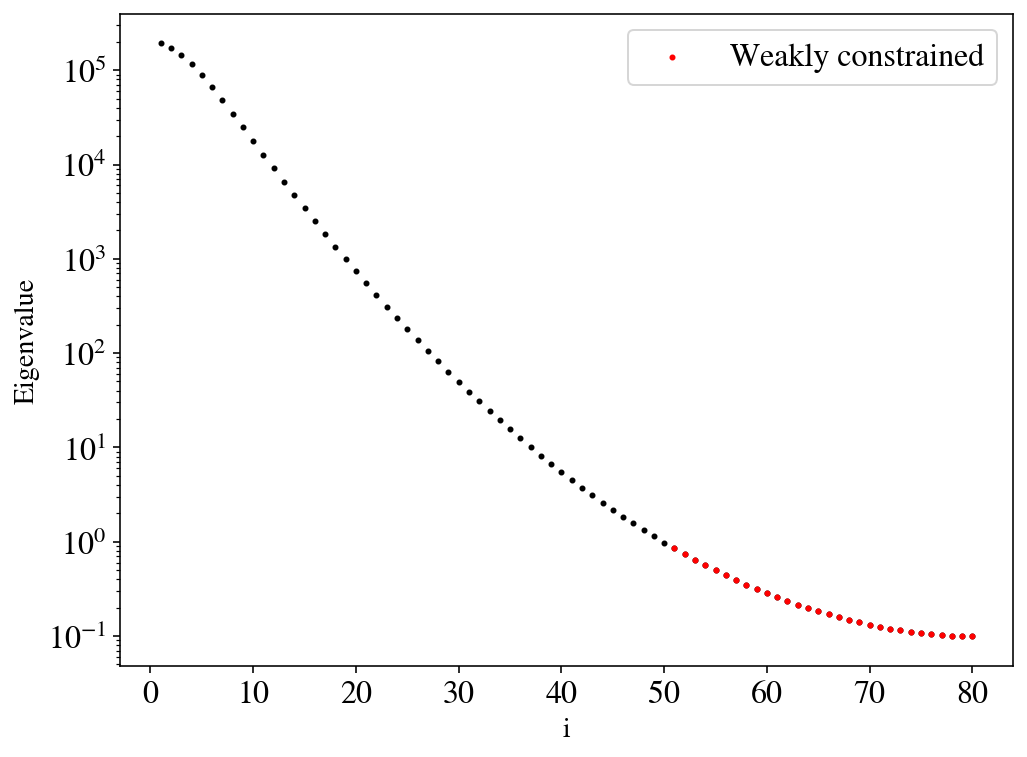

In [3]:
Npert = int(data.Npert)

Pcov = np.zeros((Npert,Npert))

sig_prior = 50

for i in np.arange(Npert):
    for j in np.arange(Npert):
        Pcov[i,j] = np.exp(-(data.pivots[i]-data.pivots[j])**2/sig_prior**2)

Pfisher = np.linalg.pinv(Pcov)        
#Pfisher = Pcov   

u, s, vh = np.linalg.svd(Pfisher)        

eigenvals = s**2
eigenvecs = vh

print(np.arange(1, Npert+1))
print(len(eigenvals))

a=np.where(eigenvals<=1)
cutoff = np.min(a)+1

fig,ax=plt.subplots()
ax.scatter(np.arange(1, Npert+1), eigenvals, color='k', s=4)
ax.scatter(np.arange(1, Npert+1)[cutoff:], eigenvals[cutoff:], color='r', s=4, label="Weakly constrained")

print(len(eigenvals[cutoff:]))

ax.set_xlabel("i", fontsize=14)
ax.set_ylabel("Eigenvalue", fontsize=14)
ax.set_yscale('log')
plt.legend()
#ax.set_xlim([50,80])
plt.show()

0.38788627471377357


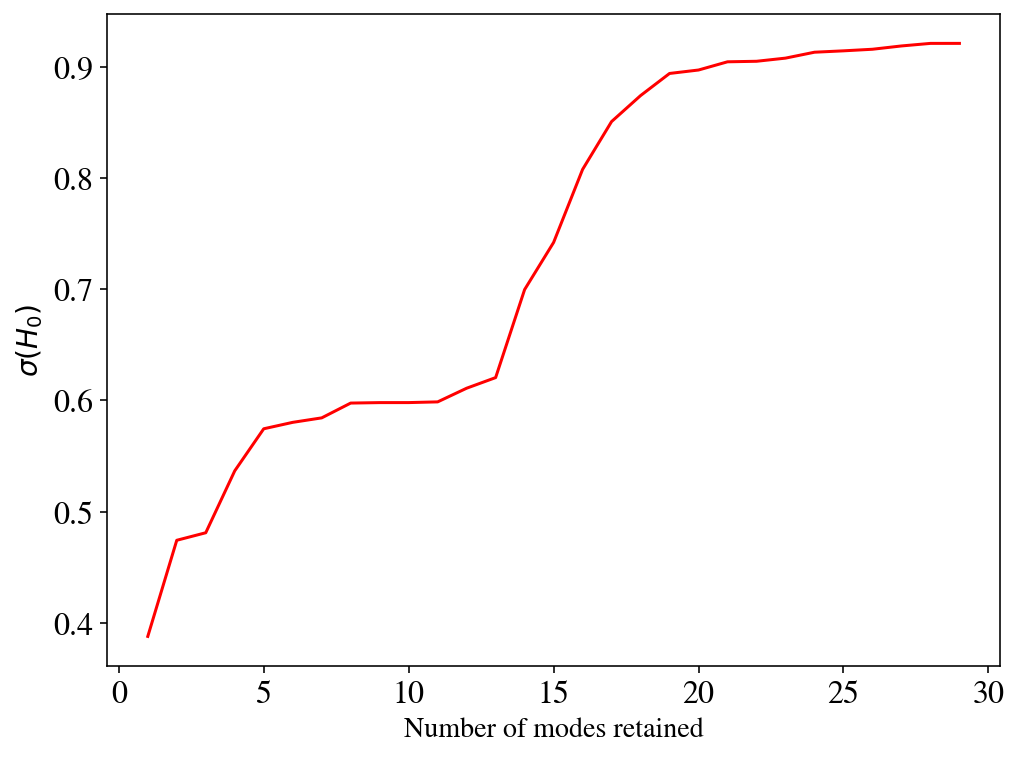

In [5]:
cutoffs = np.arange(1,30)
out_H0 = []
for Nmodes in cutoffs:
    Projection_sub = np.zeros((Npert, Nmodes))

    for i in np.arange(Nmodes):
        Projection_sub[:, i] = eigenvecs[-(i+1)]

    Projection = np.zeros((1+Npert, 1+Nmodes))
    Projection[0,0] = 1.0
    Projection[1:, 1:] = Projection_sub

    fin = np.einsum("ij,jk,kl->il", Projection.T, marginalized, Projection)

    inv = np.linalg.inv(fin)
    out_H0.append(inv[0,0])
out_H0 = np.array(out_H0)
print(np.sqrt(out_H0[0]))
fig,ax=plt.subplots()
ax.plot(cutoffs, np.sqrt(out_H0), color="r")
ax.set_xlabel("Number of modes retained", fontsize=14)
ax.set_ylabel("$\sigma(H_0)$", fontsize=14)
plt.savefig("../results/H0_mode_prior_eigen.png", dpi=300, bbox_inches='tight')
plt.show()

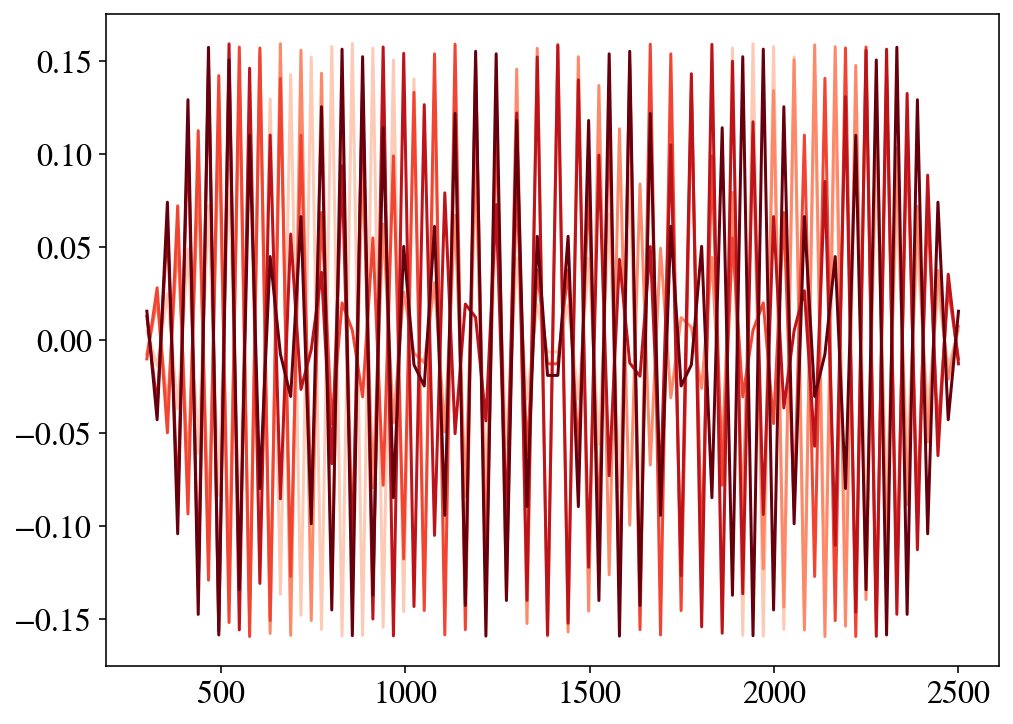

In [119]:
import matplotlib as mpl
import cycler
n = 5
my_cm = plt.cm.Reds
color = my_cm(np.linspace(.2,1,n))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

fig,ax=plt.subplots()

modes = np.arange(0, n)

for i in modes:
    ax.plot(data.pivots, eigenvecs[(i+1)])

## sigma(H0) is a monotonic function

In [218]:
prior_sigmas = np.logspace(-4, 2, 100)
H0_sigmas = []

for sig_prior in prior_sigmas:
    Fisher = data.Fisher.copy()
    Fprior_block = np.zeros((Npert,Npert))
    
    for i in np.arange(Npert):
        for j in np.arange(Npert):
            #Fprior_block[i,j] = (1/np.sqrt(2*np.pi*sig_prior**2))*np.exp(-0.5*(data.pivots[i]-data.pivots[j])**2/sig_prior**2)
            #Fprior_block[i,j] = np.exp(-0.5*(data.pivots[i]-data.pivots[j])**2/sig_prior**2)


    Fprior_block = np.linalg.pinv(Fprior_block)
    Fprior = np.zeros(Fisher.shape)
    Fprior[6:, 6:] = Fprior_block

    Fisher+=Fprior

    ####################
    # Calculating the mode
    #
    #####################
    divider = 5

    standard_block = Fisher[:divider, :divider]
    cross_block = Fisher[:divider, divider:]
    perturbation_block = Fisher[divider:, divider:]

    marginalized = perturbation_block - np.einsum("ai,ij,jk->ak", cross_block.T, np.linalg.inv(standard_block), cross_block)

    H0_row = marginalized[0,1:]
    block = marginalized[1:,1:]
    binv = np.linalg.inv(block)

    mode = np.einsum("i,ij->j", H0_row, binv)

    F_00 = marginalized[0,0]
    num = np.einsum("a,ab,b", H0_row, binv, H0_row)
    sig2 = 1./(F_00-num)
    H0_sigmas.append(np.sqrt(sig2))

H0_sigmas = np.array(H0_sigmas)

## Collecting into a single cell